# Initializer

In [ ]:
import os
from google.colab import drive

## Initializer class

In [ ]:
class Initializer:
  spark = None

  @classmethod
  def init_spark(self):
    !pip install -q findspark
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    !pip install pyspark
    !wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
    !tar xf spark-3.3.0-bin-hadoop3.tgz
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
    import findspark
    from pyspark.sql import SparkSession
    findspark.init()
    self.spark = SparkSession.builder.master("local[*]").getOrCreate()


  @classmethod
  def download_dataset(self):
    !pip install kaggle
    !mkdir .kaggle
    !mv kaggle.json .kaggle
    !mv .kaggle /root/
    !chmod 600 /root/.kaggle/kaggle.json

    !kaggle datasets download -d yelp-dataset/yelp-dataset
    !unzip yelp-dataset
  
  @classmethod
  def mount_google():
    from google.colab import drive
    drive.mount('/content/drive')

## Initializer Facade

In [ ]:
class InitializerFacade:
  def __init__(self):
    self.initializer = Initializer

  def run(self):
    self.initializer.init_spark()
    self.initializer.download_dataset()

# Dataset

In [ ]:
class YelpDataset:
  review_file = "/content/yelp_academic_dataset_review.json"
  business_file = "/content/yelp_academic_dataset_business.json"

  @classmethod
  def loading_businesses(self):
    businesss_json = spark.read.json(self.business_file)
    businesss_json.createOrReplaceTempView("businesses")

  @classmethod
  def loading_reviews(self):
    review_json = spark.read.json(self.review_file)
    review_json.createOrReplaceTempView("reviews")

  @classmethod
  def get_city_df(self, city):
    query = "SELECT reviews.text, reviews.stars, reviews.user_id, reviews.business_id FROM reviews INNER JOIN businesses ON businesses.business_id=reviews.business_id where state='{}';".format(city)
    review_list = spark.sql(query)
    return review_list.toPandas()

  @classmethod
  def get_city_items_df(self, city):
    query = "SELECT * FROM businesses WHERE state='{}'".format(city)
    city_list = spark.sql(query)
    return city_list.toPandas()


  @classmethod
  def no_businesses_by_state(self):
    return spark.sql("select state, count(business_id) as no_businesses from businesses group by state order by no_businesses desc")

  @classmethod
  def no_reviews_by_state(self):
    return spark.sql("select state, sum(review_count) as totalReview from businesses group by state order by totalReview desc")



# Main

In [ ]:
InitializerFacade().run()
spark = Initializer.spark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 55 kB/s 
     |████████████████████████████████| 199 kB 66.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=93ff6b9254602c95ff3696da828baa7972b2bc282eac072db54c4b02655ec59d
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 4.07G/4.07G [01:55<00:00, 51.3MB/s]
100% 4.07G/4.07G [01:55<00:00, 37.9MB/s]
Archive:  yelp-dataset.zip
  inflating: Dataset_User_Agreement.pdf  
  inflating: yelp_academic_dataset_business.json  
  inflating: yelp_academic_dataset_checkin.json  
  inflating: yelp_academic_dataset_review.json  
  inflating: yelp_academic_dataset_tip.json  
  inflating: yelp_academic_dataset_user.json 

In [ ]:
YelpDataset.loading_businesses()
YelpDataset.loading_reviews()
review_first_df = YelpDataset.get_city_df('CA')
review_second_df = YelpDataset.get_city_df('NJ')
print(review_second_df.shape, review_first_df.shape)

(260897, 4) (348856, 4)


In [ ]:
review_second_df_org = review_first_df
review_second_df_org = review_second_df 

In [ ]:
TEST_SIZE = 50000
TRAIN_SIZE = 50000
NNH_TRAIN_SIZE = 50000
SENTIMENT_DATAFRAME_SIZE = 50000
TOP_N_RECOMMENDATION = 10

In [ ]:
review_limited_first_df = review_first_df[:TEST_SIZE]
review_limited_second_df = review_second_df[:SENTIMENT_DATAFRAME_SIZE]

In [ ]:
review_first_df = review_first_df[:TRAIN_SIZE]
review_second_df = review_second_df[:TRAIN_SIZE]

In [ ]:
review_limitedNNH_second_df = review_second_df[:NNH_TRAIN_SIZE]

In [ ]:
review_limited_second_df

,text,stars,user_id,business_id
0,Excellent service! Great diner food and breakf...,4.0,GtqEcbHF-WTfKlms9250ZQ,7wQEzj-0yOpLiANNLuUflQ
1,Really good burger. I had the Bourbon Black an...,3.0,n6rI5T6klu0KCz0q2tS9Ng,c5QMFe_yhgksThaR2a6rtg
2,Eat here at least 2 times a week. Servers are ...,5.0,ubOMW9s0Bhi_GGPeG8Uq7g,hy5GpGXAna-5qrb3zNub6g
3,Steve & his partner are the best! Love that he...,5.0,dCOonQ7Md1ooief37g1SHw,rrD5LY3nkyKMg1CYKKZomQ
4,It's no different than any other Chinese place...,3.0,lbDYppQgGowSJIeD3xS4eA,W2mcChlYqeVirWSWSLgoDA
...,...,...,...,...
149995,Stopped in for some vegetable samosas. Perfect...,5.0,DDItoaNRmJJYrhJGz4ZJ3w,Jyh16p7IGKs3z62IJR4MPw
149996,First time here. Just finished a delicious ch...,4.0,nG13UnOYqLuroGCr9gTeGQ,kg8N1PNJM5cJmSkafUZ0Ug
149997,COFFEE STOP REVIEW:\n\nWhen the sign on the do...,3.0,-G7Zkl1wIWBBmD0KRy_sCw,82gbDck145sIpkPH3wuc4A
149998,So I'm not the type to complain about restaura...,1.0,ajkp62yLB7NJTI00vgLM-A,C4alYKA7QUKmP7diWP1M2A


# Statisticts of data

Number of businesses in each state

In [ ]:
totalBusinessesByState = YelpDataset.no_businesses_by_state()
totalBusinessesByState.show()

+-----+-------------+
|state|no_businesses|
+-----+-------------+
|   PA|        34039|
|   FL|        26330|
|   TN|        12056|
|   IN|        11247|
|   MO|        10913|
|   LA|         9924|
|   AZ|         9912|
|   NJ|         8536|
|   NV|         7715|
|   AB|         5573|
|   CA|         5203|
|   ID|         4467|
|   DE|         2265|
|   IL|         2145|
|   TX|            4|
|   CO|            3|
|   MA|            2|
|   WA|            2|
|   HI|            2|
|   MI|            1|
+-----+-------------+
only showing top 20 rows



Number of reviews in each state

In [ ]:
totalReviewByState = YelpDataset.no_reviews_by_state()
totalReviewByState.show()

+-----+-----------+
|state|totalReview|
+-----+-----------+
|   PA|    1540790|
|   FL|    1119926|
|   LA|     743176|
|   TN|     598195|
|   MO|     483897|
|   IN|     472565|
|   AZ|     412639|
|   NV|     409950|
|   CA|     339637|
|   NJ|     249837|
|   ID|     152086|
|   AB|     105477|
|   DE|      67370|
|   IL|      49676|
|   MA|         43|
|   SD|         42|
|   TX|         33|
|   HI|         32|
|   CO|         30|
|   NC|         29|
+-----+-----------+
only showing top 20 rows




# Sentiment with BERT

## Packages

In [ ]:
!pip install transformers
import numpy as np
import transformers
from transformers import AutoTokenizer,TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 29.7 MB/s 
     |████████████████████████████████| 120 kB 51.9 MB/s 
     |████████████████████████████████| 6.6 MB 50.2 MB/s 


## Bert Class

In [ ]:
class SentimentBert:
  
  def __init__(self):
    # self.limit_len = limit_len
    # self.is_limited = is_limited
    # if is_limited:
    #   self.dataset = dataset[:limit_len]
    # else:
    #   self.dataset = dataset
    # self.input_ids = input_ids
    # self.attention_mask = attention_mask
    pass
  
  @classmethod
  def tokenizer(self, text):
    # Tokenize the input (takes some time) 
    # here tokenizer using from bert-base-cased
    tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
    return tokenizer(
      text=text.tolist(),
      add_special_tokens=True,
      max_length=70,
      truncation=True,
      padding=True, 
      return_tensors='tf',
      return_token_type_ids = False,
      return_attention_mask = True,
      verbose = True)

  def get_model(self, max_len=70):
    self.bert = TFBertModel.from_pretrained('bert-base-cased')
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    # input_ids = self.input_ids
    # input_mask = self.attention_mask
    embeddings = self.bert(input_ids,attention_mask = input_mask)[0] 
    out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    out = Dense(128, activation='relu')(out)
    out = tf.keras.layers.Dropout(0.1)(out)
    out = Dense(32,activation = 'relu')(out)
    y = Dense(6,activation = 'sigmoid')(out)
    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
    return model

  def get_optimizer(self):
    return Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

  def get_loss(self):
    return CategoricalCrossentropy(from_logits = True)

  def metrics(self):
    return CategoricalAccuracy('balanced_accuracy')

  def compile(self):
    model = self.get_model()
    model.compile(
      optimizer = self.get_optimizer(),
      loss = self.get_loss(), 
      metrics = self.metrics())
    return model

  def train(self, x_train, y_train, x_validation, y_validation, epochs=1): # tokenized data
    model = self.compile()
    train_history = model.fit(
        x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
        y = y_train,
        validation_data = (
        {'input_ids':x_validation['input_ids'],'attention_mask':x_validation['attention_mask']}, y_validation
        ),
        epochs=epochs,
    )
    return model, train_history

  def test(self, model, test): # tokenized data
    return model.predict({'input_ids':test['input_ids'],'attention_mask':test['attention_mask']})

  def numerical_test(self, model, test):
    test_result = self.test(model, test)
    return [np.argmax(item) for item in test_result]

  @classmethod
  def get_dictionary(self, numerical_prediction):
    review_limited_first_df['predicted'] = numerical_prediction
    return dict(review_limited_first_df.groupby('business_id')['predicted'].mean())

  @classmethod
  def save_dictionary(self, dictionary, path='./sentiment_dict.npy'):
    np.save(path, dictionary) 

  @classmethod
  def load_dictionary(self, path='./sentiment_dict.npy'):
    return np.load(path,allow_pickle='TRUE').item()

  @classmethod
  def evaluate(self, y_true, y_predicted):
    return classification_report(y_true, y_predicted)


## Bert Facade

In [ ]:
class BertFacade:

  def __init__(self, train_dataset, test_dataset):
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset
    
  # def tokenizer(self):
  #   tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
  #   bert = TFBertModel.from_pretrained('bert-base-cased')

  #   x_train_sentiment = SentimentBert.tokenizer(x_train_sentiment)
  #   x_validation_sentiment = SentimentBert.tokenizer(x_validation_sentiment)
  #   x_test_first_token = SentimentBert.tokenizer(x_test_first)


  def run(self):

    reviews = self.train_dataset["text"]
    labels = self.train_dataset["stars"]
    x_train, x_validation, y_train, y_validation = train_test_split(reviews, labels, test_size=0.2, random_state=42)
    y_train = to_categorical(y_train)
    x_train = SentimentBert.tokenizer(x_train)
    y_validation = to_categorical(y_validation)
    x_validation = SentimentBert.tokenizer(x_validation)

    # input_ids = x_train['input_ids']
    # attention_mask = x_train['attention_mask']
    sentiment_obj = SentimentBert()
    model, _ = sentiment_obj.train(x_train, y_train, x_validation, y_validation)


    x_test = self.test_dataset['text']
    y_test = self.test_dataset['stars']
    x_test_token = SentimentBert.tokenizer(x_test)
    sentiment_predicted = sentiment_obj.numerical_test(model, x_test_token)
    print(sentiment_predicted[0])
    print(len(sentiment_predicted))

    sentiment_dictionary = SentimentBert.get_dictionary(sentiment_predicted)

    print(SentimentBert.evaluate(np.array(y_test), sentiment_predicted))

    return sentiment_dictionary, sentiment_predicted, sentiment_obj


## Run

In [ ]:
bertFacade_obj = BertFacade(review_limited_second_df, review_limited_first_df)
sentiment_dictionary, sentiment_predicted, sentiment_obj = bertFacade_obj.run()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` 

3750/3750 [==============================] - 1998s 529ms/step - loss: 0.8375 - balanced_accuracy: 0.6546 - val_loss: 0.7819 - val_balanced_accuracy: 0.6738
1
150000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

         1.0       0.69      0.82      0.75     18330
         2.0       0.44      0.31      0.36     10175
         3.0       0.47      0.41      0.44     12885
         4.0       0.51      0.39      0.44     28641
         5.0       0.81      0.90      0.85     79969

    accuracy                           0.71    150000
   macro avg       0.59      0.57      0.57    150000
weighted avg       0.69      0.71      0.69    150000



In [ ]:
# sentiment_obj.test(review_first_df)

In [ ]:
# sentiment_obj.save_dictionary(sentiment_dictionary)

NameError: ignored

In [ ]:
sentiment_dictionary = SentimentBert.load_dictionary('new.npy')

# Collaborative Recommender

## Packages


In [ ]:
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 339 kB 27.0 MB/s 
     |████████████████████████████████| 11.8 MB 28.3 MB/s 
     |████████████████████████████████| 12.4 MB 33.3 MB/s 
     |████████████████████████████████| 61 kB 7.6 MB/s 
     |████████████████████████████████| 310 kB 68.1 MB/s 
     |████████████████████████████████| 355 kB 63.1 MB/s 
     |████████████████████████████████| 197 kB 73.0 MB/s 
     |████████████████████████████████| 636 kB 69.4 MB/s 
     |████████████████████████████████| 390 kB 70.4 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705380 sha256=887066e18a59d3ba904333c08ad1a979ab572a1f65a536d09db277c56f79138c
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=fa394

In [ ]:
from surprise import Reader, SVD, SVDpp, NMF
from surprise import Dataset, accuracy
from surprise.model_selection import train_test_split, KFold
from surprise.prediction_algorithms.predictions import Prediction
from sklearn.linear_model import LinearRegression
import numpy as np
from collections import defaultdict

## Precision functions

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

## Collab Class


In [ ]:
class Collab:
  def __init__(self, model):
    self.model = model

  def train(self, data, threshold=3.5):
    kf = KFold(n_splits=5)
    last_avgprec = 0
    last_avgrec = 0
    rmse = []
    mse = [] 
    mae = [] 
    for trainset, testset in kf.split(data):
        self.model.fit(trainset)
        predictions = self.model.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=threshold)

        last_avgprec = sum(prec for prec in precisions.values()) / len(precisions)
        last_avgrec = sum(rec for rec in recalls.values()) / len(recalls)
        rmse.append(accuracy.rmse(predictions, verbose=True))
        mse.append(accuracy.mse(predictions, verbose=True))
        mae.append(accuracy.mae(predictions, verbose=True))
        print(last_avgprec)
        print(last_avgrec)

    return predictions

  def test(self, test):
    return self.model.test(test)

  def report(self, prediction, labels):
    return classification_report(labels, prediction)

  def evaluate(self, prediction):
    precision, recall = precision_recall_at_k(prediction, k=10, threshold=3.5)
    accuracy.rmse(prediction, verbose=True)
    accuracy.mse(prediction, verbose=True)
    accuracy.mae(prediction, verbose=True)
    print ("Precision: ", sum(prec for prec in precision.values()) / len(precision))
    print ("Recall: ", sum(rec for rec in recall.values()) / len(recall))

## Collab Facade




In [ ]:
class CollabFacade:
  def __init__(self, model, train, test):
    self.train = train
    self.test = test
    self.model = model

  def run(self):
    reader = Reader()
    data = Dataset.load_from_df(self.train[['user_id', 'business_id', 'stars']], reader)
    data_test = [list(self.test[['user_id', 'business_id', 'stars']].loc[i]) for i in range(len(self.test))]
    collab_obj = Collab(self.model)
    collab_obj.train(data)
    prediction = collab_obj.test(data_test)
    collab_obj.evaluate(prediction)

    return prediction, collab_obj

## Collab Run

In [ ]:
svdFacade_obj = CollabFacade(SVD(), review_first_df, review_limited_first_df)
svd_predictions, svd_obj = svdFacade_obj.run()

RMSE: 1.2557
MSE: 1.5768
MAE:  0.9801
0.6691615577821138
0.6751406420208587
RMSE: 1.2557
MSE: 1.5767
MAE:  0.9792
0.6693518543415024
0.6754940938217383
RMSE: 1.2625
MSE: 1.5938
MAE:  0.9855
0.6656096523418814
0.6721048019907987
RMSE: 1.2580
MSE: 1.5826
MAE:  0.9818
0.6688282247190108
0.674320798663296
RMSE: 1.2594
MSE: 1.5860
MAE:  0.9835
0.6683808988244512
0.6741410780358099
RMSE: 0.8892
MSE: 0.7907
MAE:  0.6703
Precision:  0.7342507960701741
Recall:  0.7380264208545485


In [ ]:
svd_predictions_rounded = [round(item.est) for item in svd_predictions]
print(svd_obj.report(svd_predictions_rounded, review_limited_first_df['stars']))

              precision    recall  f1-score   support

         1.0       0.97      0.05      0.10     18330
         2.0       0.16      0.16      0.16     10175
         3.0       0.25      0.49      0.33     12885
         4.0       0.33      0.82      0.47     28641
         5.0       0.95      0.50      0.66     79969

    accuracy                           0.48    150000
   macro avg       0.53      0.41      0.34    150000
weighted avg       0.72      0.48      0.49    150000



# Content based Recommendation


## Packages

In [ ]:
import pandas as pd

## Content Class

In [ ]:
class Content:

  def __init__(self, city):
    self.ca_df = YelpDataset.get_city_items_df(city)
    business_id_unique = set(review_first_df['business_id'])
    self.ca_df = self.ca_df[self.ca_df['business_id'].isin(list(business_id_unique))]


  def business_unique_categories(self):
    s = set()
    for item_list in self.ca_df['categories'].tolist():
      for item in item_list:
        s.add(item)
    return len(s)

  def create_poi_matrix(self):
    self.ca_df.dropna(subset=['categories'], inplace=True)
    self.ca_df['categories'] = self.ca_df.categories.str.split(',')
    self.ca_df['categories'] = self.ca_df['categories'].apply(lambda categoryList: [item.strip() for item in categoryList])

    poi_with_categories = self.ca_df[['business_id', 'categories']].copy()    
    for index, row in poi_with_categories.iterrows():
      for category in row['categories']:
        poi_with_categories.at[index, category] = 1
    poi_with_categories = poi_with_categories.fillna(0)

    poi_with_categories = poi_with_categories.drop('categories', 1)

    return poi_with_categories
    
  def create_user_profile(self, user_input_list, poi_with_categories):
    input_businesses =  pd.DataFrame(user_input_list)
    user_businesses = poi_with_categories[poi_with_categories['business_id'].isin(input_businesses['business_id'].tolist())]

    user_businesses = user_businesses.reset_index(drop=True)
    user_categories = user_businesses.drop('business_id', 1)
    return user_categories.transpose().dot(input_businesses['rating'])

  def get_user_profile_score(self, user_profile):
    userProfileDic = dict(user_profile)
    categoryWeight = dict()
    for key, value in userProfileDic.items():
      if value > 0:
        categoryWeight[key] = value
    return categoryWeight
  
  def remove_user_input_businesses(self, user_input_list, poi_with_categories):
    input_businesses =  pd.DataFrame(user_input_list)
    businesses_except_input = poi_with_categories[~poi_with_categories['business_id'].isin(input_businesses['business_id'].tolist())]
    businesses_except_input = businesses_except_input.reset_index(drop=True)

    all_businesses = businesses_except_input.drop('business_id', 1)
    return all_businesses, businesses_except_input

  def recommend(self, all_businesses, user_profile):
    recommendation_df = ((all_businesses * user_profile).sum(axis=1)) / (user_profile.sum())
    recommendation_df = recommendation_df.sort_values(ascending=False)
    sorted_result = recommendation_df.head(TOP_N_RECOMMENDATION)
    return sorted_result

  def recommendation_details(self, businesses_except_input, sorted_result) :
    recommendation_ids = businesses_except_input.iloc[sorted_result.index]['business_id']
    details = self.ca_df.merge(recommendation_ids, how = 'right')
    return recommendation_ids, details



## User input

In [ ]:
# IL
# userInput = [
#             {'business_id':'nwN92Uje-xIKE5voPTTvBQ', 'rating':1}, 
#             {'business_id':'gfQmLdpBzhs_y1sQhIzjBQ', 'rating':5}, # res
#             {'business_id':'7P6-It26918v6JDWcYlKSw', 'rating':3}, # res - chinese
#             {'business_id':"wbLXXbI-T6Av71i9AoiZRQ", 'rating':4}, # res - american
#             {'business_id':'tMsQnjwF4T8_a_JbfbaCFw', 'rating':5}, # Food
#             {'business_id':'EvBeuDww_OCNQZ-dRy6qzA', 'rating':1}, # korean - res
#             {'business_id':'RLaS9hQJXAc7ED2wr9dWeA', 'rating':3}, # res - mexican
#             {'business_id':'ZEd_RWWRVGqLlM5DUiXCeA', 'rating':4}, # coffee - mexican
#             {'business_id':'NRiBKVQro4594a8_dDgwsg', 'rating':5}, # italian - res
#             {'business_id':'2ptjkvLvDmD3zzEXzM3tsQ', 'rating':4}, # mexican - seafood
#          ] 

userInput = [ 
            {'business_id':'6EizP0XyqITuGZ8GZMI9Lw', 'rating':1}, # Italian 
            {'business_id':'XyYsl2OyoMi6OMvzsdcVoQ', 'rating':5}, # Italian 
            {'business_id':'QLHgjBHBoeIUoEvIPvjHnw', 'rating':3}, # burger 
            {'business_id':"QaFbv7aLQBcfT4xMF1_WnQ", 'rating':4}, # burger 
            {'business_id':'9u79dIXLQzmt9rnOZEnBaQ', 'rating':5}, # burger 
            {'business_id':'bp482wqF6v80AltDNlPDfw', 'rating':1}, # burger 
            {'business_id':'1FURjeGJi_LBXcJQg8eskw', 'rating':3}, # burger 
            {'business_id':'nYPzsOjvida-ne7swSPHpA', 'rating':4}, # bar - mexican 
            {'business_id':'4kfbEcAMepvkjt3H7INYBg', 'rating':5}, # bar 
            {'business_id':'EZc2myE2mYk2h9JK9qu8gw', 'rating':4.5}, # bar - burgers
]

## Content Facade

In [ ]:
class ContentFacade:
  def run(self):
    obj = Content("CA")
    poi_with_categories = obj.create_poi_matrix()
    user_profile = obj.create_user_profile(userInput, poi_with_categories)
    # obj.get_user_profile_score(user_profile)
    all_businesses, businesses_except_input = obj.remove_user_input_businesses(userInput, poi_with_categories)
    result = obj.recommend(all_businesses, user_profile)
    recommendation_ids, details = obj.recommendation_details(businesses_except_input, result)
    return recommendation_ids


In [ ]:
contentFacade_obj = ContentFacade()
content_ids = contentFacade_obj.run()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


ValueError: ignored

# Hybrid recommender using multilinear regression (+ Testing for NNH)

## RegHybrid Class

In [ ]:
class RegHybrid:
  def __init__(self, pred1, pred2):
    self.pred1 = pred1
    self.pred2 = pred2
    self.w1 = None
    self.w2 = None
    self.interceptor = None

  @classmethod
  def formatting_input(self, pred1, pred2):
    reg_items = []
    reg_actual = []
    for index in range(len(pred1)):
      pred1_item = pred1[index].est
      pred2_item = pred2[index].est

      reg_items.append([pred1_item, pred2_item])
      reg_actual.append(pred1[index].r_ui)
    
    return np.array(reg_items), np.array(reg_actual)

  def train(self):
    x_train, y_train = self.formatting_input(self.pred1, self.pred2)
    reg = LinearRegression().fit(x_train, y_train)
    print('regression score:', reg.score(x_train, y_train))
    print('weights:', reg.coef_)
    self.w1, self.w2, self.interceptor = reg.coef_[0], reg.coef_[1], reg.intercept_
    return reg
    
  def test(self, model, x_test):
    return model.predict(x_test)

  @classmethod
  def evaluate(self, y_true, y_predicted):
    return classification_report(y_true, y_predicted)

  def get_predictions(self):
    prediction_list = []
    for index in range(len(self.pred1)):
      weighted_prediction = self.w1*self.pred1[index].est + self.w2*self.pred2[index].est + self.interceptor
      pred_obj = self.pred1[index]
      item = Prediction(
        uid=pred_obj.uid,
        iid=pred_obj.iid,
        r_ui=pred_obj.r_ui,
        est=weighted_prediction,
        details=pred_obj.details
      )
      prediction_list.append(item)

    return prediction_list

  def metrics(self, threshold=3.5):
    prediction_list = self.get_predictions()

    precision, recall = precision_recall_at_k(prediction_list, k=10, threshold=threshold)
    accuracy.rmse(prediction_list, verbose=True)
    accuracy.mse(prediction_list, verbose=True)
    accuracy.mae(prediction_list, verbose=True)
    print ("Precision: ", sum(prec for prec in precision.values()) / len(precision))
    print ("Recall: ", sum(rec for rec in recall.values()) / len(recall))
    

## Hybrid Facade

In [ ]:
class RegHybridFacade:
  def __init__(self, pred1, pred2, pred_test1, pred_test2):
    self.pred1 = pred1
    self.pred2 = pred2
    self.pred_test1= pred_test1
    self.pred_test2 = pred_test2

  def run(self):
    regHybrid_obj = RegHybrid(self.pred1, self.pred2)
    reg = regHybrid_obj.train()

    x_test, y_test = regHybrid_obj.formatting_input(self.pred_test1, self.pred_test2)
    predicted = regHybrid_obj.test(reg, x_test)
    predicted_rounded = [round(item) for item in predicted]
    print(regHybrid_obj.evaluate(y_test, predicted_rounded))
    return predicted, regHybrid_obj


## Collabs Run

In [ ]:
svdppFacade_obj = CollabFacade(SVDpp(), review_first_df, review_limited_first_df)
svdpp_predictions, svdpp_obj = svdppFacade_obj.run()
nmfFacade_obj = CollabFacade(NMF(), review_first_df, review_limited_first_df)
nmf_predictions, nmf_obj = nmfFacade_obj.run()

## Hybrid Run

In [ ]:
hybridFacade_obj = RegHybridFacade(nmf_predictions, svdpp_predictions, nmf_predictions, svdpp_predictions)
hybrid_predicted, hybrid_obj = hybridFacade_obj.run()

In [ ]:
hybrid_predictions = hybrid_obj.get_predictions()

# Hybrid recommender using multilinear regression with monolethic approach 

## Packages

In [ ]:
!pip install recommenders
from surprise import Reader, SVDpp, NMF
from surprise import Dataset, accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.predictions import Prediction
from sklearn.linear_model import LinearRegression
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Constructing monolethic dataframe

In [ ]:
contentbased_output = review_first_df.merge(content_ids, how = 'right')
monolethic_input = contentbased_output[['user_id', 'business_id', 'stars']]
monolethic_input.head()

,user_id,business_id,stars
0,NaN,DOfiulOub9hVPBCtiDl9Fw,NaN
1,NaN,sz5SMsTOTAshdfsaK98-TA,NaN
2,NaN,kbWKwvLXfJm5sLVfw-Foww,NaN
3,NaN,thlyktt2c7v1DyOpSVSibw,NaN
4,NaN,-NXRuUsazxXZZ_OHwmtYtw,NaN


In [ ]:
len(monolethic_input)

175

## Running collabs for monolethic

In [ ]:
svdppFacade_mono_obj = CollabFacade(SVDpp(), review_first_df, monolethic_input)
svdpp_mono_predictions, svdpp_mono_obj = svdppFacade_mono_obj.run()
nmfFacade_mono_obj = CollabFacade(NMF(), review_first_df, monolethic_input)
nmf_mono_predictions, nmf_mono_obj = nmfFacade_mono_obj.run()

RMSE: 1.2937
MSE: 1.6738
MAE:  1.0179
0.6721838764315261
0.6788387237995323
RMSE: 1.2871
MSE: 1.6566
MAE:  1.0147
0.6712341134394572
0.6777319704113772
RMSE: 1.2908
MSE: 1.6661
MAE:  1.0158
0.6741169980148655
0.6809428821939877
RMSE: 1.2904
MSE: 1.6651
MAE:  1.0149
0.677059479563948
0.6857725968447177
RMSE: 1.2798
MSE: 1.6378
MAE:  1.0059
0.6803032054245649
0.6879673884042541
RMSE: nan
MSE: nan
MAE:  nan
Precision:  0.6595092024539877
Recall:  0.6625766871165644
RMSE: 1.4517
MSE: 2.1076
MAE:  1.1464
0.6294393876553946
0.6315606640547765
RMSE: 1.4597
MSE: 2.1306
MAE:  1.1518
0.6233644080231394
0.6247460990280417
RMSE: 1.4585
MSE: 2.1271
MAE:  1.1507
0.6271398341581188
0.6293355161566562
RMSE: 1.4481
MSE: 2.0970
MAE:  1.1397
0.6272696070711841
0.6290087856292199
RMSE: 1.4496
MSE: 2.1014
MAE:  1.1438
0.6291059576131864
0.6308568784306855
RMSE: nan
MSE: nan
MAE:  nan
Precision:  0.6042944785276073
Recall:  0.6073619631901841


## Running Hybrid Mono

In [ ]:
hybridFacade_mono_obj = RegHybridFacade(nmf_mono_predictions, svdpp_mono_predictions, nmf_mono_predictions, svdpp_mono_predictions)
hybrid_mono_predicted, hybrid_mono_obj = hybridFacade_mono_obj.run()

ValueError: ignored

In [ ]:
hybrid_mono_predictions = hybrid_mono_obj.get_predictions()

NameError: ignored

# Training for NNH

In [ ]:
svdppFacade_train_obj = CollabFacade(SVDpp(), review_second_df, review_limitedNNH_second_df)
svdpp_train_predictions, svdpp_train_obj = svdppFacade_train_obj.run()
nmfFacade_train_obj = CollabFacade(NMF(), review_second_df, review_limitedNNH_second_df)
nmf_train_predictions, nmf_train_obj = nmfFacade_train_obj.run()

In [ ]:
hybridFacade_train_obj = RegHybridFacade(nmf_train_predictions, svdpp_train_predictions, nmf_train_predictions, svdpp_train_predictions)
hybrid_train_predicted, hybrid_train_obj = hybridFacade_train_obj.run()

In [ ]:
hybrid_trains_predictions = hybrid_train_obj.get_predictions()

# Hybrid With NNH

## Packages

In [ ]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.metrics import classification_report

## NN4Hybrid Class

In [ ]:
class NN4Hybrid:
  
  def __init__(self):
    self.train_history = None
  

  def get_model(self):
    hidden_units1 = 160
    hidden_units2 = 480
    hidden_units3 = 256
    model = Sequential([
      Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
      Dropout(0.2),
      Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
      Dropout(0.2),
      Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
      Dense(1, kernel_initializer='normal', activation='linear')
    ])
    return model

  def get_optimizer(self, learning_rate=0.01):
    return Adam(learning_rate=learning_rate)

  def get_loss(self):
    return MeanSquaredLogarithmicError()

  def metrics(self):
    return [self.get_loss()]

  def compile(self):
    model = self.get_model()
    model.compile(
      optimizer = self.get_optimizer(),
      loss = self.get_loss(), 
      metrics = self.metrics())
    return model

  def train(self, x_train, y_train, epochs=1):
    model = self.compile()
    train_history = history = model.fit(
        x_train, 
        y_train, 
        epochs=10, 
        batch_size=100,
        validation_split=0.2
    )
    self.train_history = train_history
    return model, train_history

  def test(self, model, test):
    return model.predict(test)

  def plot_history(self, key='mean_squared_logarithmic_error'):
    plt.plot(self.train_history.history[key])
    plt.plot(self.train_history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()

  def get_predictions(self, predicted, pred1):
    prediction_list = []
    for index in range(len(predicted)):
      weighted_prediction = predicted[index]
      pred_obj = pred1[index]
      item = Prediction(
        uid=pred_obj.uid,
        iid=pred_obj.iid,
        r_ui=pred_obj.r_ui,
        est=weighted_prediction,
        details=pred_obj.details
      )
      prediction_list.append(item)

    return prediction_list

  @classmethod
  def evaluate(self, y_true, y_predicted):
    return classification_report(y_true, y_predicted)


## NN4Hybrid Facade

In [ ]:
class NN4HybridFacade:
  def __init__(self, pred1, pred2, x_test, y_test):
    self.pred1 = pred1
    self.pred2 = pred2
    self.x_test = x_test
    self.y_test = y_test

  def run(self):
    x_train, y_train = RegHybrid.formatting_input(self.pred1, self.pred2)
    nnh_obj = NN4Hybrid()
    model, train_history = nnh_obj.train(x_train, y_train)
    nnh_obj.plot_history()
    x_test, y_test = RegHybrid.formatting_input(self.x_test, self.y_test)
    predicted = nnh_obj.test(model, x_test)
    predicted_rounded = [round(item[0]) for item in predicted]
    print(nnh_obj.evaluate(y_test, predicted_rounded))

    return predicted_rounded, nnh_obj


## Run

Epoch 1/10
400/400 [==============================] - 6s 4ms/step - loss: 0.0493 - mean_squared_logarithmic_error: 0.0493 - val_loss: 0.0458 - val_mean_squared_logarithmic_error: 0.0458
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0391 - mean_squared_logarithmic_error: 0.0391 - val_loss: 0.0383 - val_mean_squared_logarithmic_error: 0.0383
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0385 - mean_squared_logarithmic_error: 0.0385 - val_loss: 0.0383 - val_mean_squared_logarithmic_error: 0.0383
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 0.0387 - mean_squared_logarithmic_error: 0.0387 - val_loss: 0.0361 - val_mean_squared_logarithmic_error: 0.0361
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.0378 - mean_squared_logarithmic_error: 0.0378 - val_loss: 0.0348 - val_mean_squared_logarithmic_error: 0.0348
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - lo

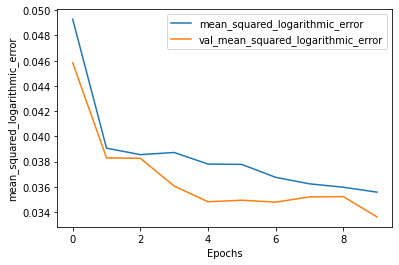

              precision    recall  f1-score   support

         1.0       0.96      0.76      0.85      5965
         2.0       0.65      0.64      0.64      3354
         3.0       0.59      0.69      0.63      4327
         4.0       0.56      0.90      0.69      9828
         5.0       0.98      0.79      0.88     26526

    accuracy                           0.79     50000
   macro avg       0.75      0.75      0.74     50000
weighted avg       0.84      0.79      0.80     50000



In [ ]:
NN4HybridFacade_obj = NN4HybridFacade(svdpp_train_predictions, nmf_train_predictions, svdpp_predictions, nmf_predictions)
nnh_predicted, nnh_obj = NN4HybridFacade_obj.run()

In [ ]:
nnh_predictions = nnh_obj.get_predictions(nnh_predicted, svdpp_predictions)

In [ ]:
regression_sen_nnh_df = pd.DataFrame([[business_dict_mean[svd_predicted[i].iid], round(nnh_predicted_item[i]), review_limited_ca_df.iloc[i]['stars']] for i in range(len(review_limited_ca_df))]
                  , columns=['Sentiment', 'NNH', 'Actual'])
regression_sen_nnh_df.head(5)

,Sentiment,NNH,Actual
0,4.515152,5,5.0
1,3.729167,4,4.0
2,3.588235,3,3.0
3,1.923077,1,1.0
4,4.642857,4,5.0


In [ ]:
regression_sen_nnh_df.shape

(15550, 3)

# Fusion class

## Packages

In [ ]:
from surprise.prediction_algorithms.predictions import Prediction
from sklearn.linear_model import LinearRegression
from transformers.models.auto import modeling_tf_auto
import pandas as pd

## Fusion class

In [ ]:
class Fusion:
  def __init__(self, sentiment_dict, recommender, actual):
    self.sentiment_dict = sentiment_dict
    self.recommender = recommender
    self.actual = actual
    
  @staticmethod
  def constructing_df(sentiment_dict, recommender, actual):
    return pd.DataFrame([[sentiment_dict[recommender[i].iid], round(recommender[i].est), round(actual.iloc[i]['stars'])] for i in range(len(actual)) if recommender[i].iid in sentiment_dict]
            , columns=['Sentiment', 'Recommender', 'Actual'])
      

  def formatting_input(self, df):
    items = []
    actuals = []
    for index in range(len(df)):
      sentiment = df.iloc[index]['Sentiment']
      hybrid = df.iloc[index]['Recommender']
      actual = df.iloc[index]['Actual']

      recommender = hybrid
      items.append([sentiment, recommender])
      actuals.append(actual)
    
    return items, actuals

  def train(self):
    df = self.constructing_df(self.sentiment_dict, self.recommender, self.actual)
    items, actual = self.formatting_input(df)
    reg = LinearRegression().fit(items, actual)

    return reg

  def test(self, model, x_test):
    return model.predict(x_test)

  def get_predictions(self, predicted, pred1):
    prediction_list = []
    for index in range(len(predicted)):
      weighted_prediction = predicted[index]
      pred_obj = pred1[index]
      item = Prediction(
        uid=pred_obj.uid,
        iid=pred_obj.iid,
        r_ui=pred_obj.r_ui,
        est=weighted_prediction,
        details=pred_obj.details
      )
      prediction_list.append(item)

    return prediction_list

  def evaluate(self, y_true, y_predicted):
    return classification_report(y_true, y_predicted)

## Fusion Facade

In [ ]:
class FusionFacade:

  def __init__(self, sentiment_dict, recommender, actual, x_test, y_test):
    self.sentiment_dict = sentiment_dict
    self.recommender = recommender
    self.actual = actual
    self.x_test = x_test
    self.y_test = y_test

  def run(self):
    fusion_obj = Fusion(self.sentiment_dict, self.recommender, self.actual)
    model = fusion_obj.train()
    predicted = fusion_obj.test(model, self.x_test)
    predicted_rounded = [round(item) for item in predicted]
    print(fusion_obj.evaluate(self.y_test, predicted_rounded))
    return predicted, fusion_obj

## Sentiment + SVD

In [ ]:
sen_svd_df = Fusion.constructing_df(sentiment_dictionary, svd_predictions, review_limited_first_df)
sen_svd_fusionFacade_obj = FusionFacade(sentiment_dictionary, svd_predictions, review_limited_first_df, sen_svd_df.iloc[:5000][['Sentiment', 'Recommender']], sen_svd_df.iloc[:5000]['Actual'])
sen_svd_fusion_predictions, sen_svd_fusion_obj = sen_svd_fusionFacade_obj.run()

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.83      0.12      0.21      1176
         2.0       0.14      0.19      0.16       479
         3.0       0.23      0.69      0.35       528
         4.0       0.26      0.61      0.37       892
         5.0       0.92      0.20      0.32      1925
         6.0       0.00      0.00      0.00         0

    accuracy                           0.30      5000
   macro avg       0.34      0.26      0.20      5000
weighted avg       0.63      0.30      0.29      5000



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels w

## Sentiment + Hybrid

In [ ]:
len (hybrid_trains_predictions)

50000

In [ ]:
#test
sen_hybrid_df = Fusion.constructing_df(sentiment_dictionary, hybrid_predictions, review_limited_first_df)

#train
sen_hybrid_fusionFacade_obj = FusionFacade(sentiment_dictionary, hybrid_trains_predictions, review_limited_second_df, sen_hybrid_df[['Sentiment', 'Recommender']], sen_hybrid_df['Actual'])
sen_hybrid_fusion_predictions, sen_hybrid_fusion_obj = sen_hybrid_fusionFacade_obj.run()

IndexError: ignored

## Sentiment + Monolethic

In [ ]:
sen_mono_df = Fusion.constructing_df(sentiment_dictionary, hybrid_mono_predictions, review_limited_first_df)
sen_hybrid_fusionFacade_obj = FusionFacade(sentiment_dictionary, hybrid_mono_predictions, review_limited_first_df, sen_mono_df.iloc[:5000][['Sentiment', 'Recommender']], sen_mono_df.iloc[:5000]['Actual'])
sen_hybrid_fusion_predictions, sen_hybrid_fusion_obj = sen_hybrid_fusionFacade_obj.run()


IndexError: ignored

## Sentiment + NNH

In [ ]:
type (round(sen_nnh_df['Actual'][0]))

int

In [ ]:
sen_nnh_df = Fusion.constructing_df(sentiment_dictionary, nnh_predictions, review_limited_first_df)
sen_nnh_fusionFacade_obj = FusionFacade(sentiment_dictionary, nnh_predictions, review_limited_first_df, sen_nnh_df.iloc[:5000][['Sentiment', 'Recommender']], sen_nnh_df.iloc[:5000]['Actual'])
sen_nnh_fusion_predictions, sen_nnh_fusion_obj = sen_nnh_fusionFacade_obj.run()

              precision    recall  f1-score   support

           1       0.95      0.81      0.88      1176
           2       0.48      0.74      0.58       479
           3       0.35      0.61      0.44       528
           4       0.27      0.35      0.30       892
           5       0.78      0.35      0.48      1925
           6       0.00      0.00      0.00         0

    accuracy                           0.52      5000
   macro avg       0.47      0.48      0.45      5000
weighted avg       0.65      0.52      0.55      5000



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels w

In [ ]:
sen_nnh_fusion_predictions

array([4.44072734, 4.50055731, 3.37467753, ..., 5.55011125, 3.37467753,
       4.48386611])

## Sentiment + NNH (Fusion With Neural Network)

# Fusion hybrid and sentiment using Neural Network

In [ ]:
sen_nnh_nnhFusion_df = Fusion.constructing_df(sentiment_dictionary, nnh_predictions, review_limited_first_df)

In [ ]:
hybrid_reg_items = []
actual_reg_items = []
for index, row in sen_nnh_nnhFusion_df.iterrows():
    hybrid_reg_items.append([row['Sentiment'], row['Recommender']])
    actual_reg_items.append(row['Actual'])

X_reg_rec =  np.array(hybrid_reg_items)
Y_reg_act =  np.array(actual_reg_items)

In [ ]:
x_nnhs_df = pd.DataFrame(X_reg_rec, columns=['Hybrid', 'Sentiment'])
y_nnhs_df = pd.DataFrame(Y_reg_act, columns=['Actual'])
x_nnhs_df.head()

,Hybrid,Sentiment
0,4.424242,4.0
1,3.729167,4.0
2,3.735294,3.0
3,2.230769,2.0
4,4.714286,4.0


In [ ]:
len(x_nnhs_df)

15550

In [ ]:
x_train_nnhs, x_test_nnhs, y_train_nnhs, y_test_nnhs = train_test_split(x_nnhs_df, y_nnhs_df, test_size=0.2, random_state=42)

In [ ]:
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
nnhs_model = build_model_using_sequential()

In [ ]:
# loss function
msle = MeanSquaredLogarithmicError()
nnhs_model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)
# train the model
history = nnhs_model.fit(
    x_train_nnhs.values, 
    y_train_nnhs.values, 
    epochs=10, 
    batch_size=100,
    validation_split=0.2
)

Epoch 1/10
100/100 [==============================] - 1s 5ms/step - loss: 0.1045 - mean_squared_logarithmic_error: 0.1043 - val_loss: 0.0424 - val_mean_squared_logarithmic_error: 0.0424
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0434 - mean_squared_logarithmic_error: 0.0435 - val_loss: 0.0407 - val_mean_squared_logarithmic_error: 0.0407
Epoch 3/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0433 - mean_squared_logarithmic_error: 0.0434 - val_loss: 0.0404 - val_mean_squared_logarithmic_error: 0.0404
Epoch 4/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0429 - mean_squared_logarithmic_error: 0.0430 - val_loss: 0.0415 - val_mean_squared_logarithmic_error: 0.0414
Epoch 5/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0436 - mean_squared_logarithmic_error: 0.0438 - val_loss: 0.0539 - val_mean_squared_logarithmic_error: 0.0539
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - lo

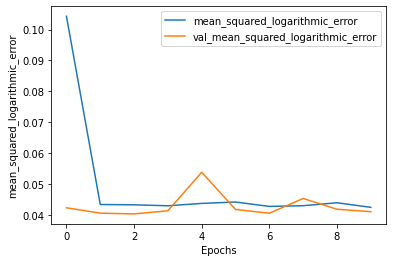

In [ ]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [ ]:
print (x_test_nnhs, Y_reg_act)

In [ ]:
nnhs_predicted = nnhs_model.predict(x_test_nnhs)

In [ ]:
nnhs_predicted = [round(item[0]) for item in nnhs_predicted]

In [ ]:
print (nnhs_predicted[10:20])
print (y_test_nnhs.iloc[10:20])

[5, 5, 5, 4, 5, 4, 1, 4, 3, 5]
       Actual
15014     5.0
10690     5.0
3479      5.0
5890      4.0
9553      5.0
6134      4.0
3550      1.0
2559      4.0
5743      1.0
13625     5.0


In [ ]:
x_test_nnhs

,Hybrid,Sentiment
8524,3.809524,4.0
8777,4.343348,4.0
3025,2.652174,1.0
8677,3.466667,4.0
2848,3.909091,5.0
...,...,...
6194,3.219178,4.0
12708,4.115942,4.0
10235,3.680851,4.0
9354,3.680851,4.0


In [ ]:
print(classification_report(y_test_nnhs, nnhs_predicted))

              precision    recall  f1-score   support

         1.0       0.95      0.79      0.86       606
         2.0       0.51      0.71      0.59       265
         3.0       0.37      0.46      0.41       302
         4.0       0.52      0.18      0.26       594
         5.0       0.70      0.71      0.70      1343
         6.0       0.00      0.00      0.00         0

    accuracy                           0.60      3110
   macro avg       0.51      0.47      0.47      3110
weighted avg       0.67      0.60      0.61      3110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
